# Creating the Dataset

In [8]:
import cv2
import numpy as np

background = None
accumulated_weight = 0.5

ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350


def cal_accum_avg(frame, accumulated_weight):

    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None

    cv2.accumulateWeighted(frame, background, accumulated_weight)


def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)

    _ , thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)

    # Grab the external contours for the image
    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None
    else:
        
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        return (thresholded, hand_segment_max_cont)

In [13]:
cam = cv2.VideoCapture(0)

num_frames = 0
element = 15
num_imgs_taken = 0

while True:
    ret, frame = cam.read()

    # filpping the frame to prevent inverted image of captured frame...
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

    if num_frames < 60:
        cal_accum_avg(gray_frame, accumulated_weight)
        if num_frames <= 59:
            
            cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT", (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
            #cv2.imshow("Sign Detection",frame_copy)
         
    #Time to configure the hand specifically into the ROI...
    elif num_frames <= 300: 

        hand = segment_hand(gray_frame)
        
        cv2.putText(frame_copy, "Adjust hand...Gesture for" + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        
        # Checking if hand is actually detected by counting number of contours detected...
        if hand is not None:
            
            thresholded, hand_segment = hand

            # Draw contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames)+"For" + str(element), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

            # Also display the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
    
    else: 
        
        # Segmenting the hand region...
        hand = segment_hand(gray_frame)
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            
            # unpack the thresholded img and the max_contour...
            thresholded, hand_segment = hand

            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            #cv2.putText(frame_copy, str(num_frames)+"For" + str(element), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            cv2.putText(frame_copy, str(num_imgs_taken) + 'images' +"For" + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            # Displaying the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
            if num_imgs_taken <= 300:
                #cv2.imwrite(r"D:\\gesture\\train\\"+str(element)+"\\" + str(num_imgs_taken+300) + '.jpg', thresholded)
                cv2.imwrite("dataset/train/" + str(element) + "/" + str(num_imgs_taken) + '.jpg', thresholded)
            elif num_imgs_taken > 300 and num_imgs_taken <= 400:
                cv2.imwrite("dataset/test/" + str(element) + "/" + str(num_imgs_taken) + '.jpg', thresholded)
            else:
                break
            num_imgs_taken +=1
        else:
            cv2.putText(frame_copy, 'No hand detected...', (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    # Drawing ROI on frame copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right, ROI_bottom), (255,128,0), 3)
    
    cv2.putText(frame_copy, "Hand Sign Recognition_ _ _", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    
    # increment the number of frames for tracking
    num_frames += 1

    # Display the frame with segmented hand
    cv2.imshow("Sign Detection", frame_copy)

    # Closing windows with Esc key...(any other key with ord can be used too.)
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

# Releasing camera & destroying all the windows...

cv2.destroyAllWindows()
cam.release()

# Training the model

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import itertools
import random
import warnings
import numpy as np
import cv2
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# warnings.simplefilter(action='ignore', category=FutureWarning)


train_path = 'dataset/train'
test_path = 'dataset/test'

train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, 
                                                                                             target_size=(64,64),
                                                                                             class_mode='categorical', 
                                                                                             batch_size=10,shuffle=True)
test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, 
                                                                                             target_size=(64,64), 
                                                                                             class_mode='categorical', 
                                                                                             batch_size=10, shuffle=True)

imgs, labels = next(train_batches)


#Plotting the images...
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()




Found 3010 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

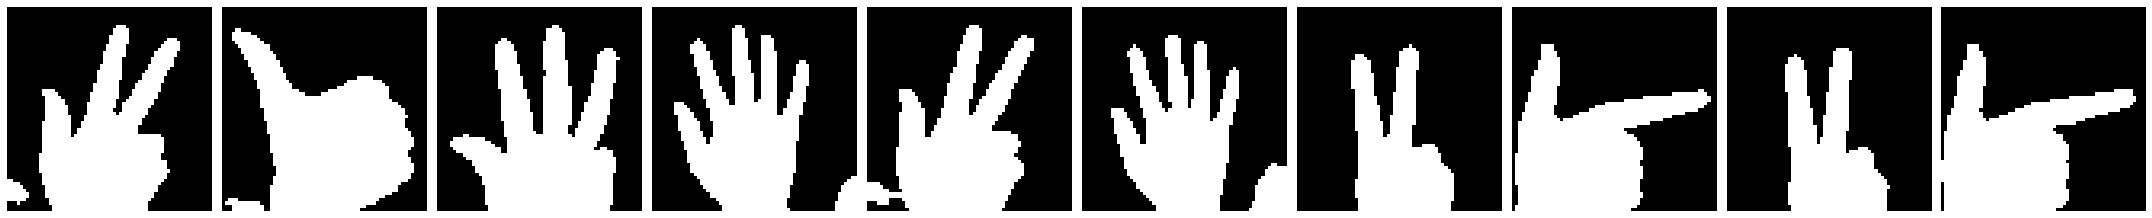

(10, 64, 64, 3)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [15]:
plotImages(imgs)
print(imgs.shape)
print(labels)



In [16]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.2))
model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.3))
model.add(Dense(10,activation ="softmax"))

print(model.summary())




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 31, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
__________

In [18]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


In [ ]:
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


In [20]:

history2 = model.fit(train_batches, epochs=10, callbacks=[reduce_lr, early_stop], validation_data = test_batches)#, checkpoint])
imgs, labels = next(train_batches) # For getting next batch of imgs...

imgs, labels = next(test_batches) # For getting next batch of imgs...
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


#model.save('best_model_dataflair.h5')
model.save('best_model_dataflair3.h5')

print(history2.history)

imgs, labels = next(test_batches)

model = keras.models.load_model(r"best_model_dataflair3.h5")

scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

model.summary()

scores #[loss, accuracy] on test data...
model.metrics_names




AttributeError: 'DirectoryIterator' object has no attribute 'ndim'

In [ ]:
word_dict = {0:'One',1:'Ten',2:'Two',3:'Three',4:'Four',5:'Five',6:'Six',7:'Seven',8:'Eight',9:'Nine'}

predictions = model.predict(imgs, verbose=0)
print("predictions on a small set of test data--")
print("")
for ind, i in enumerate(predictions):
    print(word_dict[np.argmax(i)], end='   ')

plotImages(imgs)
print('Actual labels')
for i in labels:
    print(word_dict[np.argmax(i)], end='   ')

print(imgs.shape)